# Sentiment Analysis
This project focuses on practicing how to handle sequence data, starting from preprocessing steps like tokenization and numericalization, and moving on to modeling. The goal is to build a sentiment analysis system that classifies user reviews using [IMDB movies dataset](https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews) from Kaggle.

## Notebook Sections
- [Importing Data & Packages](#Importing-Data-&-Packages)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
    * [Initial Data Exploration](#Initial-Data-Exploration)
    * [Exploring some random sentences](#Exploring-some-random-sentences)
    * [Exploring the size of the text](#Exploring-the-size-of-the-text)
    * [Cleaning Text](#Cleaning-Text)
- [Preprocessing Data](#Preprocessing-Data)
    * [Tokenization](#Tokenization)
    * [Padding Sentences](#Padding-Sentences)
    * [Constructing a Vocab & Numericalization](#Constructing-a-Vocab-&-Numericalization)
    * [Encode Target Data](#Encode-Target-Data)
    * [Preparing X & Y](#Preparing-X-&-Y)
- [Model Development Process](#Model-Development-Process)
    * [Try to reduce overfitting](#Try-to-reduce-overfitting)
    * [Comparing between the two Models](#Comparing-between-the-two-Models)

***الله المستعان***

---
---

## Importing Data & Packages

In [ ]:
# Data Processing 
import numpy as np
import pandas as pd
import random 
from collections import Counter

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Model Development
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Custom Modules
from utils.clean_text import clean_text, get_unique_chars
from utils.preprocess import tokenize_text, pad_sequence
from utils.model_development import load_glove_vecs, pretrained_embedding_layer, sentences_to_indices
from utils.model_development import batch_train_generator, batch_val_generator, build_model

# Savings
import pickle


In [2]:
df0 = pd.read_csv("data/IMDB_Dataset.csv")
df0.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


---
---

## Exploratory Data Analysis (EDA)

### Initial Data Exploration

In [3]:
df0.shape

(50000, 2)

In [4]:
df0.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df0.duplicated(subset = [col for col in df0.columns]).sum()

np.int64(418)

In [6]:
df0[df0.duplicated(keep = False)].sort_values(by = [col for col in df0.columns])

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
2976,"""Witchery"" might just be the most incoherent a...",negative
...,...,...
47876,this movie sucks. did anyone notice that the e...,negative
23056,"well, the writing was very sloppy, the directi...",negative
44122,"well, the writing was very sloppy, the directi...",negative
10163,"when I first heard about this movie, I noticed...",positive


In [7]:
df1 = df0.drop_duplicates()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [9]:
df1.sentiment.value_counts(normalize = True)

sentiment
positive    0.501876
negative    0.498124
Name: proportion, dtype: float64

### Exploring some random sentences

In [10]:
sentences = df1['review'].tolist()

In [11]:
random_sentences = []
for _ in range(20):
    idx = random.randint(0, 5000)
    random_sentences.append(sentences[idx])

In [12]:
for sentence in random_sentences:
    print(sentence)
    print(100 * '-')

Oh my God, I was so expecting something more entertaining than this when I downloaded this movie, seeing as 1903 was one of my fave years for movies ever, but it sucked! The "plot", although I'd hesitate to call it that, is about some dumb elephant. It slowly makes its way onto some platform and gets electrocuted to death. Lame. Even for a short film, the plot was too thin to keep my attention. Edison is, like, the worst director ever. Plus, the elephant has no screen presence whatsoever. And the ending? Wow, that wasn't predictable at all. *sarcasm*<br /><br />The picture quality is horrible too. You can barely tell what's going on most of the time. The only positive thing about this movie is that unlike most other un-scary horror flicks this didn't spawn eleven sequels. Other than that this is a complete waste of money and 1 minute of your life you'll never get back.
----------------------------------------------------------------------------------------------------
Ladies and Gentle

### Exploring the size of the text

#### Min & Max Chars

In [13]:
min(df1['review'].str.len()), max(df1['review'].str.len())

(32, 13704)

In [14]:
min_chars = 32
max_chars = 13704

In [15]:
df1.loc[df1['review'].str.len() == min_chars]

,review,sentiment
27521,"Read the book, forget the movie!",negative


In [16]:
df1.loc[df1['review'].str.len() == max_chars]

,review,sentiment
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive


In [17]:
print(str(df1.loc[df1['review'].str.len() == max_chars, 'review'].values))

['Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, b

#### Min & Max Words

In [18]:
min(df1['review'].str.split().apply(len)), max(df1['review'].str.split().apply(len))

(4, 2470)

In [19]:
min_words = 4
max_words = 2470

In [20]:
df1[df1['review'].str.split().apply(len) == min_words]

,review,sentiment
28920,Primary plot!Primary direction!Poor interpreta...,negative


In [21]:
df1[df1['review'].str.split().apply(len) == max_words]

,review,sentiment
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive


#### Exploring the unique chars in our data

In [22]:
sentences_list = df1['review'].tolist()

In [23]:
unique_chars = get_unique_chars(sentences_list)
len(unique_chars)

162

In [24]:
print(unique_chars)

{'\x80', '\x9a', 't', '|', '1', '³', '9', '\x9e', 'p', 'z', '°', 'u', ' ', 'o', '\x96', '.', '¤', 'ï', '…', 'w', '(', '\x08', '★', '3', '=', '–', 'g', '?', '§', '»', '¾', '+', 'n', 'ø', '\x8d', '¦', '\\', 'j', 'é', '*', 'á', '7', 'ö', 'ō', '₤', '~', '^', '\x10', 'i', '[', 'ã', 'º', 'ç', 'י', 'a', '\x8e', 'ë', 'ú', '“', 'ò', 's', 'õ', '!', '”', '>', ']', '#', '·', 'l', '¨', 'ı', 'ן', '\uf0b7', '`', '@', 'ü', 'מ', '\xa0', 'x', '\x85', '\xad', 'à', 'א', '0', 'v', 'h', '"', '¡', 'ג', 'ä', '‘', '{', '，', '’', '5', ';', ',', 'm', '2', '\x97', 'ó', 'æ', '©', 'כ', 'ו', '6', 'å', '\x84', 'î', '\x91', '-', '\t', 'r', 'ż', 'í', 'f', '´', 'ר', 'ל', 'û', 'þ', 'ß', '®', 'â', '%', 'ý', 'ô', 'ì', 'ª', 'q', '▼', '8', 'ð', 'è', 'd', '\x95', ')', 'c', '¢', '«', 'e', '_', 'k', 'y', '/', '″', '4', 'b', ':', '$', '}', "'", '½', 'ñ', '、', '¿', 'ù', '£', '&', '<', 'ğ', 'ê'}


### Cleaning Text

In [25]:
# Apply the cleaning to the dataset 
df_cleaned = df1.copy()
df_cleaned['cleaned_review'] = df_cleaned['review'].apply(clean_text) # clean_text code in utils.clean_text
df_cleaned.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei's love in the time of money is a...


In [26]:
cleaned_unique_chars = get_unique_chars(df_cleaned['cleaned_review'].tolist())
len(cleaned_unique_chars)

43

In [27]:
print(cleaned_unique_chars)

{'q', '8', 't', '7', 'd', '5', '1', 'c', 'i', ',', 'm', '2', '9', 'p', 'e', 'a', 'k', 'z', 'y', '4', 'u', ' ', 'o', '6', 's', 'b', '!', '.', '0', "'", 'r', 'w', 'l', 'f', '★', '3', 'x', 'g', '?', 'n', 'v', 'h', 'j'}


---
---

## Preprocessing Data

### Tokenization

In [28]:
df_tokenized = df_cleaned.copy()
df_tokenized['tokenized'] = df_tokenized['cleaned_review'].apply(tokenize_text)

In [29]:
df_tokenized['tokenized'][0]

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'oz',
 'episode',
 "you'll",
 'be',
 'hooked',
 '.',
 'they',
 'are',
 'right',
 ',',
 'as',
 'this',
 'is',
 'exactly',
 'what',
 'happened',
 'with',
 'me',
 '.',
 'the',
 'first',
 'thing',
 'that',
 'struck',
 'me',
 'about',
 'oz',
 'was',
 'its',
 'brutality',
 'and',
 'unflinching',
 'scenes',
 'of',
 'violence',
 ',',
 'which',
 'set',
 'in',
 'right',
 'from',
 'the',
 'word',
 'go',
 '.',
 'trust',
 'me',
 ',',
 'this',
 'is',
 'not',
 'a',
 'show',
 'for',
 'the',
 'faint',
 'hearted',
 'or',
 'timid',
 '.',
 'this',
 'show',
 'pulls',
 'no',
 'punches',
 'with',
 'regards',
 'to',
 'drugs',
 ',',
 'sex',
 'or',
 'violence',
 '.',
 'its',
 'is',
 'hardcore',
 ',',
 'in',
 'the',
 'classic',
 'use',
 'of',
 'the',
 'word',
 '.',
 'it',
 'is',
 'called',
 'oz',
 'as',
 'that',
 'is',
 'the',
 'nickname',
 'given',
 'to',
 'the',
 'oswald',
 'maximum',
 'security

### Padding Sentences

In [30]:
df_tokenized['num_of_tokens'] = df_tokenized['tokenized'].apply(len)
df_tokenized.head()

,review,sentiment,cleaned_review,tokenized,num_of_tokens
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...",351
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil...",168
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...",177
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,"[basically, there's, a, family, where, a, litt...",145
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei's love in the time of money is a...,"[petter, mattei's, love, in, the, time, of, mo...",252


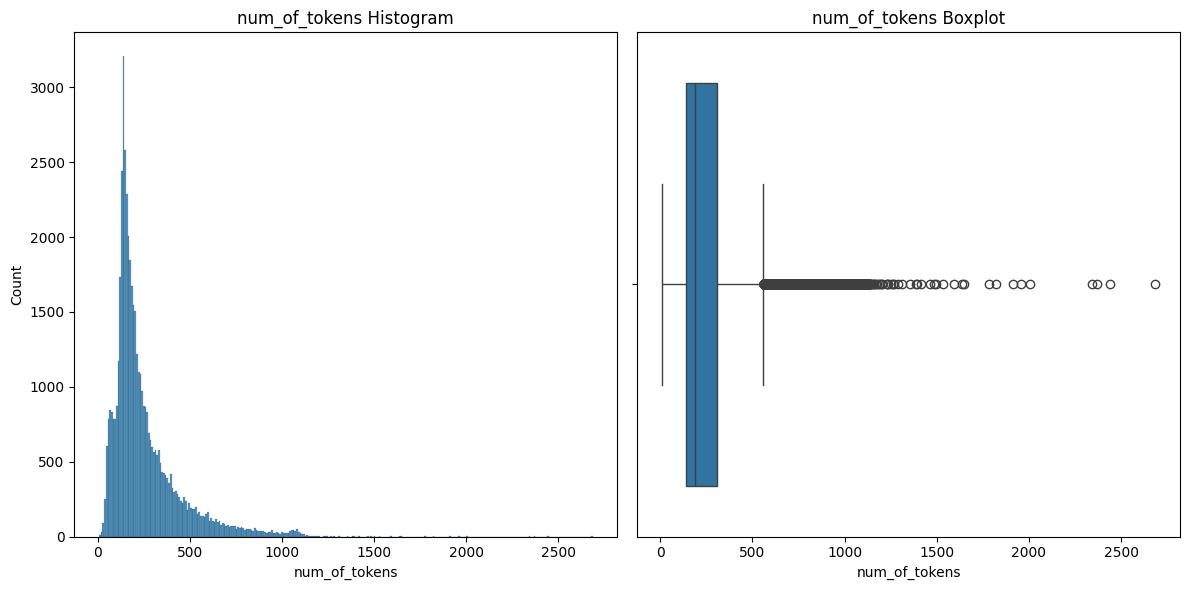

In [31]:
# Examine the distribution of the lengths
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

sns.histplot(
    data = df_tokenized,
    x = 'num_of_tokens',
    ax = ax1
)

sns.boxplot(
    data = df_tokenized,
    x = 'num_of_tokens',
    ax = ax2
)

ax1.set_title("num_of_tokens Histogram", fontsize = 12); ax2.set_title("num_of_tokens Boxplot", fontsize = 12);
plt.tight_layout()
plt.show()                               

In [32]:
df_tokenized['num_of_tokens'].describe()

count    49582.000000
mean       252.929370
std        186.357183
min          8.000000
25%        139.000000
50%        190.000000
75%        307.000000
max       2686.000000
Name: num_of_tokens, dtype: float64

In [33]:
df_tokenized[( (df_tokenized['num_of_tokens'] >= 50) & (df_tokenized['num_of_tokens'] <= 300) )].shape

(36118, 5)

we will standardize the review lengths as follows:
- Filter out reviews shorter than 50 tokens (to remove extremely short and uninformative reviews).
- Truncate reviews longer than 300 tokens.
- Apply <pad> tokens to make all reviews 300 tokens long.

In [34]:
LOWER_LIMIT = 50
UPPER_LIMIT = 300
df_tokenized = df_tokenized[df_tokenized['num_of_tokens'] >= LOWER_LIMIT]

In [35]:
df_tokenized.num_of_tokens.describe()

count    48899.000000
mean       255.891266
std        185.947121
min         50.000000
25%        141.000000
50%        192.000000
75%        309.000000
max       2686.000000
Name: num_of_tokens, dtype: float64

In [36]:
df_tokenized.shape

(48899, 5)

In [37]:
df_padded = df_tokenized.copy()
df_padded['padded'] = df_padded['tokenized'].apply(
    lambda x: pad_sequence(x, max_len = UPPER_LIMIT)
)
df_padded['num_of_padded_tokens'] = df_padded['padded'].apply(len)

In [38]:
df_padded.num_of_padded_tokens.describe()

count    48899.0
mean       300.0
std          0.0
min        300.0
25%        300.0
50%        300.0
75%        300.0
max        300.0
Name: num_of_padded_tokens, dtype: float64

In [39]:
df_padded.shape

(48899, 7)

### Constructing a Vocab & Numericalization

In [40]:
all_tokens = [token for sentence in df_padded['padded'] for token in sentence]
len(all_tokens)

14669700

In [41]:
# construct a vocab of 30K words
VOCAB_SIZE = 30000
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(VOCAB_SIZE)
vocab = [word for word, _ in most_common_words]
vocab[0:10]

['<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', 'is', 'in']

In [42]:
idx_to_word = {idx:word for idx, word in enumerate(vocab)}
word_to_idx = {word:idx for idx, word in enumerate(vocab)}

### Encode Target Data

In [43]:
df_padded.sentiment.value_counts()

sentiment
positive    24488
negative    24411
Name: count, dtype: int64

In [44]:
df_encoded = df_padded.copy()
encoding_dict = {
    'positive' : 1,
    'negative' : 0
}
df_encoded['sentiment'] = df_encoded['sentiment'].map(encoding_dict)
df_encoded.sentiment.value_counts()

sentiment
1    24488
0    24411
Name: count, dtype: int64

### Preparing X & Y

In [45]:
df_train = df_encoded[['padded', 'sentiment']]
df_train.head()

,padded,sentiment
0,"[one, of, the, other, reviewers, has, mentione...",1
1,"[a, wonderful, little, production, ., the, fil...",1
2,"[i, thought, this, was, a, wonderful, way, to,...",1
3,"[basically, there's, a, family, where, a, litt...",0
4,"[petter, mattei's, love, in, the, time, of, mo...",1


In [46]:
# Splitting data for train & test

X = df_train['padded']
Y = df_train['sentiment']
X_train, X_, Y_train, Y_ = train_test_split(
    X, Y,
    test_size = 0.2,
    random_state = 0
)

In [47]:
X_val, X_test, Y_val, Y_test = train_test_split(
    X_, Y_,
    test_size = 0.5,
    random_state = 0
)

In [48]:
X_train.shape, Y_train.shape

((39119,), (39119,))

In [49]:
X_val.shape, Y_val.shape

((4890,), (4890,))

In [50]:
X_test.shape, Y_test.shape

((4890,), (4890,))

---
---

## Model Development Process

In [51]:
%%time

# Loading the glove embeddings
word_to_vec_map = load_glove_vecs("data/glove.6B.50d.txt")

CPU times: total: 2.98 s
Wall time: 3 s


In [52]:
BATCH_SIZE = 32
LSTM_UNITS = 80
KEEP_PROB = 0.8
INPUT_SHAPE = UPPER_LIMIT
OUTPUT_SHAPE = 1

In [ ]:
# model = build_model(
#     lstm_units = LSTM_UNITS,
#     keep_prob  = KEEP_PROB,
#     input_shape = INPUT_SHAPE,
#     output_shape = OUTPUT_SHAPE,
#     word_to_vec_map = word_to_vec_map,
#     word_to_idx = word_to_idx
# )

# loss = 'categorical_crossentropy' if OUTPUT_SHAPE > 1 else 'binary_crossentropy'
# model.compile(
#     loss = loss,
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-3, clipnorm = 1.0),
#     metrics = ['accuracy']
# )

In [ ]:
# batch_train_gen = batch_train_generator(list(X_train), list(Y_train), word_to_idx, batch_size=BATCH_SIZE)
# batch_val_gen = batch_val_generator(list(X_val), list(Y_val), word_to_idx, batch_size=BATCH_SIZE)

In [ ]:
# %%time



# model.fit(
#     batch_train_gen,
#     steps_per_epoch = len(X_train) // BATCH_SIZE,
#     validation_data = batch_val_gen,
#     validation_steps = len(X_val) // BATCH_SIZE,
#     epochs = 10
# )


Epoch 1/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 170s 138ms/step - accuracy: 0.5127 - loss: 0.6943 - val_accuracy: 0.4688 - val_loss: 0.6922
Epoch 2/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 168s 138ms/step - accuracy: 0.6417 - loss: 0.5874 - val_accuracy: 0.9688 - val_loss: 0.1643
Epoch 3/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 170s 139ms/step - accuracy: 0.8935 - loss: 0.2666 - val_accuracy: 0.9375 - val_loss: 0.1218
Epoch 4/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 172s 141ms/step - accuracy: 0.9350 - loss: 0.1839 - val_accuracy: 0.8750 - val_loss: 0.1434
Epoch 5/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 171s 140ms/step - accuracy: 0.9620 - loss: 0.1204 - val_accuracy: 0.8750 - val_loss: 0.2383
Epoch 6/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 168s 138ms/step - accuracy: 0.9770 - loss: 0.0795 - val_accuracy: 0.9688 - val_loss: 0.1598
Epoch 7/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 166s 136ms/step - accuracy: 0.9817 - loss: 0.0628 - val_accuracy: 0.9688 - val_loss: 0.2239
Epoch 8/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 167s 136ms/step - ac

In [ ]:
# Saving the model
# model.save('sentiment_analysis_model_v1.keras')

In [55]:
# Evaluate the model performance on test set
X_test_indices = sentences_to_indices(list(X_test), word_to_idx)
Y_test = np.array(list(Y_test)).reshape(-1, 1)
# model.evaluate(
#     X_test_indices,
#     Y_test
# )

### Try to reduce overfitting


In [ ]:
%%time

loss = 'categorical_crossentropy' if OUTPUT_SHAPE > 1 else 'binary_crossentropy'

model_v2 = build_model(80, 0.7, INPUT_SHAPE, OUTPUT_SHAPE, word_to_vec_map, word_to_idx)
model_v2.layers[-1].kernel_regulaizer = tf.keras.regularizers.l2(1e-4)


model_v2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-3),  # learning rate منخفض
    loss = loss,
    metrics = ['accuracy']
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    restore_best_weights = True
)


# batch_train_gen = batch_train_generator(list(X_train), list(Y_train), word_to_idx, batch_size=BATCH_SIZE)
# batch_val_gen = batch_val_generator(list(X_val), list(Y_val), word_to_idx, batch_size=BATCH_SIZE)

# history = model_v2.fit(
#     batch_train_gen,
#     steps_per_epoch = len(X_train) // BATCH_SIZE,
#     validation_data = batch_val_gen,
#     validation_steps = len(X_val) // BATCH_SIZE,
#     epochs=10,       
#     callbacks=[early_stopping_cb]
# )

Epoch 1/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 144s 116ms/step - accuracy: 0.5229 - loss: 0.6876 - val_accuracy: 0.8750 - val_loss: 0.3478
Epoch 2/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.8524 - loss: 0.3743 - val_accuracy: 0.9375 - val_loss: 0.1898
Epoch 3/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 153s 125ms/step - accuracy: 0.9101 - loss: 0.2502 - val_accuracy: 0.9375 - val_loss: 0.1720
Epoch 4/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 164s 134ms/step - accuracy: 0.9479 - loss: 0.1588 - val_accuracy: 0.8438 - val_loss: 0.4100
Epoch 5/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 144s 118ms/step - accuracy: 0.9715 - loss: 0.1001 - val_accuracy: 0.8750 - val_loss: 0.4323
Epoch 6/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 135s 110ms/step - accuracy: 0.9819 - loss: 0.0695 - val_accuracy: 0.8750 - val_loss: 0.4168
CPU times: total: 56min 24s
Wall time: 14min 33s


In [ ]:
# model_v2.evaluate(
#     X_test_indices,
#     Y_test
# )

153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8799 - loss: 0.3237


[0.3043332099914551, 0.8865030407905579]

In [ ]:
# model_v2.save("models/sentiment_analysis_model_v2.keras")

### Comparing between the two Models

In [53]:
model_v1 = tf.keras.models.load_model("models/sentiment_analysis_model_v1.keras")
model_v2 = tf.keras.models.load_model("models/sentiment_analysis_model_v2.keras")

In [56]:
# Prediction
model_v1_preds = model_v1.predict(X_test_indices)
model_v2_preds = model_v2.predict(X_test_indices)

153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step


In [57]:
model_v1_classes = model_v1_preds >= 0.5
model_v2_classes = model_v2_preds >= 0.5


In [59]:
print(f'For Model#1')
print(f'Acc: {round(accuracy_score(Y_test, model_v1_classes), 4)}')
print(f'Precision: {round(precision_score(Y_test, model_v1_classes), 4)}')
print(f'Recall: {round(recall_score(Y_test, model_v1_classes), 4)}')
print(f'F1: {round(f1_score(Y_test, model_v1_classes), 4)}')
print(100 * '-')
print(f'For Model#2')
print(f'Acc: {round(accuracy_score(Y_test, model_v2_classes), 4)}')
print(f'Precision: {round(precision_score(Y_test, model_v2_classes), 4)}')
print(f'Recall: {round(recall_score(Y_test, model_v2_classes), 4)}')
print(f'F1: {round(f1_score(Y_test, model_v2_classes), 4)}')

For Model#1
Acc: 0.8783
Precision: 0.8677
Recall: 0.8855
F1: 0.8765
----------------------------------------------------------------------------------------------------
For Model#2
Acc: 0.8865
Precision: 0.9078
Recall: 0.8541
F1: 0.8801


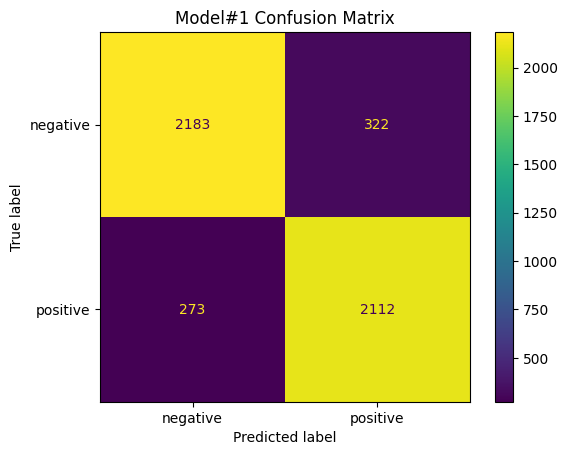

In [60]:
cm = confusion_matrix(Y_test, model_v1_classes)
cm_disp = ConfusionMatrixDisplay(cm, display_labels = ['negative', 'positive'])
cm_disp.plot()
plt.title("Model#1 Confusion Matrix")
plt.show()

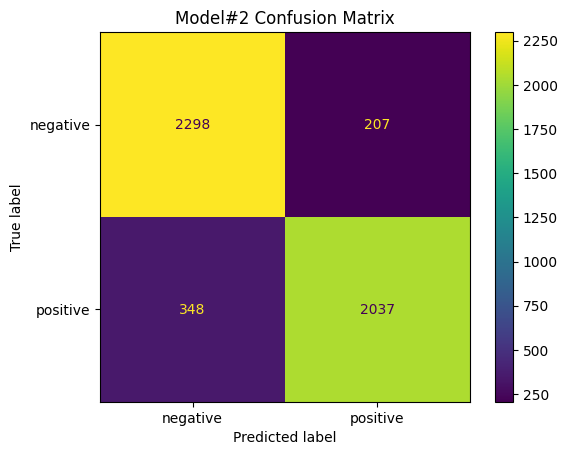

In [61]:
cm = confusion_matrix(Y_test, model_v2_classes)
cm_disp = ConfusionMatrixDisplay(cm, display_labels = ['negative', 'positive'])
cm_disp.plot()
plt.title("Model#2 Confusion Matrix")
plt.show()

- Both models exhibit slight overfitting, but Model 2 demonstrates slightly better generalization.

In [ ]:
# saving the word_to_idx dict
with open('data/word_to_idx.pkl', 'wb') as f:
    pickle.dump(word_to_idx, f)

---
---

<b><i>ALHAMDULILLAH</i></b>